# Battery Degradation Modeling for Cell Life Assessment

This notebook demonstrates semi-empirical battery degradation models based on electrochemical principles. The models implement SEI growth, active material loss, and comprehensive stress factor analysis.

## Key Features:
- **Multiple Model Types**: Semi-Empirical-1 (data-driven) and Semi-Empirical-2 (non-linearity additions to initial model)
- **Multi-Battery Model Support**: EVE306, CATL280, and BAT314 battery options
- **Degradation analysis**: Temperature, DoD, SoC, and C-rate sensitivity
- **BOL Calculation**: Based on EOL and Project Life requirements given by the user
- **Report Production**: Results are given in a pdf with a table and graph showing annual degradation values

## Scientific Foundation:
The models are based on fundamental degradation mechanisms:
- **SEI Growth**: Parabolic law (diffusion-limited) with Arrhenius temperature dependence
- **Active Material Loss**: Stress-based particle cracking and isolation
- **Lithium Plating**: Low-temperature and high C-rate effects
- **Resistance Growth**: SEI layer impedance and contact resistance increase

In [ ]:
# Core scientific computing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import the battdegr package (after installation with: pip install -e .)
import sys
sys.path.insert(0, '../src')  # Add source directory to path

try:
    from battdegr.models import MechanisticModel, SemiEmpiricalModel, EmpiricalModel
    # from battdegr.analysis import LifetimePredictor, StressFactorAnalysis
    print("✓ BattDegr package imported successfully!")
except ImportError as e:
    print(f"Warning: Could not import battdegr package: {e}")
    print("Running in standalone mode with inline implementations...")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("\n" + "="*60)
print("Battery Degradation Modeling Toolkit".center(60))
print("="*60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print("="*60)

✓ BattDegr package imported successfully!

            Battery Degradation Modeling Toolkit            
NumPy version: 2.2.6
Pandas version: 2.3.3
Matplotlib version: 3.10.8


## 2. Model Selection and Configuration

Choose your degradation model type and battery chemistry. This notebook supports:
- **Semi-Empirical Model 1**: Power-law relationships with stress factors based on original paper
- **Semi-Empirical Model 2**: Power-law relationships with stress factors with additional non-linearity based on project life year

In [14]:
# ============================================================================
# MODEL SELECTION - CHANGE THESE PARAMETERS
# ============================================================================
 
# Choose model type: 'semi_empirical_1', 'semi_empirical_2'
MODEL_TYPE = 'semi_empirical_1'  # <-- CHANGE THIS BASED ON THE MODEL DESIRED

# Choose battery: EVE306, CATL, BAT
BATTERY_MODEL = 'EVE306'  # <-- CHANGE THIS BASED ON THE ACTUAL BATTERY

# Project life is in years, either 15 or 20
PROJECT_LIFE = 15

# EOL (nominal) capacity of the project [MWh], MUST BE > 0
EOL_CAPACITY_REQ = 300.0

# ============================================================================

print("\n" + "="*70)
print("MODEL CONFIGURATION".center(70))
print("="*70)
print(f"Model Type:      {MODEL_TYPE.upper()}")
print(f"Battery model:   {BATTERY_MODEL}")
print(f"Project Life:    {PROJECT_LIFE} years")
print(f"EOL Capacity:    {EOL_CAPACITY_REQ} MWh")
print("="*70)

# Initialize the selected model
if MODEL_TYPE == 'semi_empirical_1':
    model = SemiEmpiricalModel(
        batt_model=BATTERY_MODEL
    )
    print("\n✓ Semi-Empirical Model 1 initialized")
    
elif MODEL_TYPE == 'semi_empirical_2':
    model = SemiEmpiricalModel(
            batt_model=BATTERY_MODEL
    )
    print("\n✓ Semi-Empirical Model 2 initialized")
    
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

# Display model-specific parameters
print("\n" + "-"*70)
print("Model Parameters:")
print("-"*70)


# CONFIRM THIS SHOWS MODEL PARAMETERS SPECIFIC TO THE BATTERY MODEL
if MODEL_TYPE == 'semi_empirical_1':
    print(f"  k_temp:      {model.k_temp:.8f}")
    print(f"  k_soc:       {model.k_soc:.8f}")
    print(f"  k_cal:       {model.k_cal:.2e}")
    print(f"  Asei:        {model.Asei:.2f}")
    print(f"  Bsei:        {model.Bsei:.2f}")
    print(f"  k_dod_1:     {model.k_dod_1:.2e}")
    print(f"  k_dod_2:     {model.k_dod_2:.2f}")
    
elif MODEL_TYPE == 'semi_empirical_2':
    print(f"  k_temp:      {model.k_temp:.8f}")
    print(f"  k_soc:       {model.k_soc:.8f}")
    print(f"  k_cal:       {model.k_cal:.2e}")
    print(f"  Asei:        {model.Asei:.2f}")
    print(f"  Bsei:        {model.Bsei:.2f}")
    print(f"  k_dod_1:     {model.k_dod_1:.2e}")
    print(f"  k_dod_2:     {model.k_dod_2:.2f}")

print("="*70 + "\n")


                         MODEL CONFIGURATION                          
Model Type:      SEMI_EMPIRICAL_1
Battery model:   EVE306
Project Life:    15 years
EOL Capacity:    300.0 MWh

✓ Semi-Empirical Model 1 initialized

----------------------------------------------------------------------
Model Parameters:
----------------------------------------------------------------------
  k_temp:      0.09272663
  k_soc:       0.82421930
  k_cal:       4.00e-10
  Asei:        0.04
  Bsei:        125.00
  k_dod_1:     6.02e-06
  k_dod_2:     1.80



## 3. Degradation Analysis

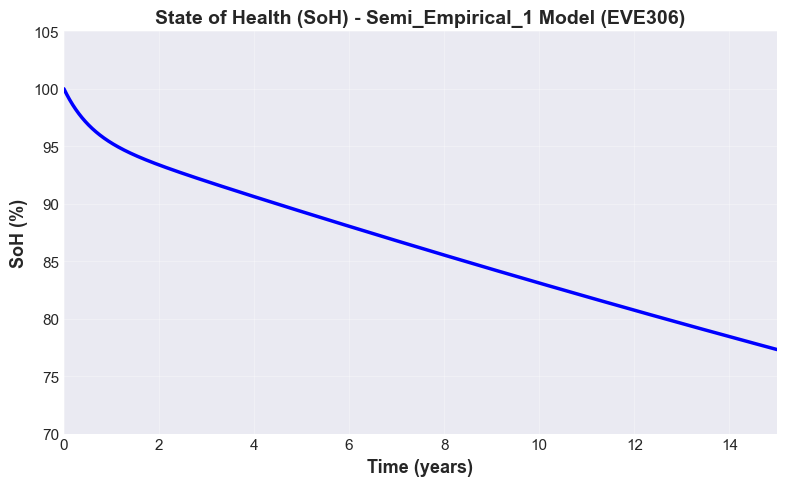


                         DEGRADATION SUMMARY                          
Operating Conditions:
  Temperature:        25°C
  Average SoC:        50%
  Depth of Discharge: 90%
  C-rate:             0.25C
  Throughput (Ac):    1.0 cycle/day
Output:
  Project Life:       15 years
  SoH at EOL:         77.31%
  EOL Energy Required:300.0 MWh
  BOL Energy Required:388.0 MWh



In [15]:
# Define simulation parameters
simulation_years = PROJECT_LIFE
temperature = 25  # °C
soc = 0.5  # Average state of charge
dod = 0.9  # Depth of discharge
Ac = 1.0 # Equivalent cycles per day
c_rate = 0.25  # should be either 0.25 (4hr battery) or 0.5 (2hr battery)

# Create time array of days depending on the length of the simulation in years
time_days = np.linspace(0, simulation_years * 365, num=((simulation_years * 365)+1))
#OLD BELOW
#time_days = np.linspace(0, simulation_years * 365, 200)
#cycles = time_days * cycles_per_day

# Predict state of health (soh)
soh = model.predict_fade(
    time_days=time_days,
    temperature=temperature,
    soc=soc,
    dod=dod,
    Ac=Ac,
    c_rate=c_rate
)

# Convert to years for plotting
time_years = time_days / 365

# Create visualization
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot: State of Health (SoH)
ax1.plot(time_years, soh, 'b-', linewidth=2.5)
"""
ax1.axhline(y=80, color='r', linestyle='--', linewidth=2, alpha=0.7, label='EOL (80%)')
ax1.fill_between(time_years, soh, 80, where=(soh >= 80), 
                  alpha=0.3, color='green', label='Operational Range')
ax1.fill_between(time_years, soh, 80, where=(soh < 80), 
                  alpha=0.3, color='red', label='Below EOL')
"""

ax1.set_xlabel('Time (years)', fontsize=13, fontweight='bold')
ax1.set_ylabel('SoH (%)', fontsize=13, fontweight='bold')
ax1.set_title(f'State of Health (SoH) - {MODEL_TYPE.title()} Model ({BATTERY_MODEL})', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, simulation_years)
ax1.set_ylim(70, 105)

plt.tight_layout()
plt.show()

# Print summary statistics, calculated BOL required below as well
print("\n" + "="*70)
print("DEGRADATION SUMMARY".center(70))
print("="*70)
print(f"Operating Conditions:")
print(f"  Temperature:        {temperature}°C")
print(f"  Average SoC:        {soc*100:.0f}%")
print(f"  Depth of Discharge: {dod*100:.0f}%")
print(f"  C-rate:             {c_rate}C")
print(f"  Throughput (Ac):    {Ac} cycle/day")
print(f"Output:")
print(f"  Project Life:       {PROJECT_LIFE:.0f} years")
print(f"  SoH at EOL:         {soh[-1]:.2f}%")
print(f"  EOL Energy Required:{EOL_CAPACITY_REQ:0.1f} MWh")
BOL = EOL_CAPACITY_REQ / (soh[-1] / 100)
print(f"  BOL Energy Required:{BOL:.1f} MWh")
print("="*70 + "\n")